# Extracción de Entidades Nombradas con CRF

En esta práctica, implementaremos un sistema de reconocimiento de entidades nombradas utilizando Conditional Random Fields (CRF). Utilizaremos el corpus CONLL2002 que contiene textos en español y holandés, con anotaciones para cuatro tipos de entidades: LOC (ubicaciones), MISC (miscelánea), ORG (organizaciones), y PER (personas).

Seguiremos un enfoque incremental:
1. Exploraremos el dataset y su estructura
2. Definiremos diferentes conjuntos de características (features)
3. Entrenaremos modelos CRF con diferentes configuraciones
4. Evaluaremos el rendimiento utilizando diversas métricas
5. Optimizaremos nuestro modelo mediante experimentación

## 1. Configuración Inicial

Primero, importaremos las bibliotecas necesarias y cargaremos los datos básicos. Importamos los archivos locations.txt y person_names.txt para posteriormente tratar los gazzetters, estos contienen listados de nombres en castellano y holandés de personas y de todos los paises y buena parte de las ciudades del mundo.

In [61]:
import re
import nltk
import pandas as pd
from nltk.corpus import conll2002
from nltk.tag import CRFTagger
from sklearn.metrics import classification_report
from typing import List, Dict, Tuple
from sklearn.metrics import balanced_accuracy_score

# Descargar los datos necesarios
nltk.download('conll2002')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Cargar gazetteers (listas de entidades conocidas)
with open("locations.txt", encoding="utf-8") as f:
    locations_set = set(line.strip().lower() for line in f if line.strip())
    print(f"Cargadas {len(locations_set)} ubicaciones en el gazetteer")

with open("person_names.txt", encoding="utf-8") as f:
    person_names_set = set(line.strip().lower() for line in f if line.strip())
    print(f"Cargados {len(person_names_set)} nombres en el gazetteer")

Cargadas 106150 ubicaciones en el gazetteer
Cargados 123466 nombres en el gazetteer


[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Carrega de dades i exploració inicial

En primer lloc, vam importar les dades d'entrenament, validació i test de cada un dels dos idiomes. Aquestes dades venien en la codificació "BIO". Més endavant aquests tags es tractarien per provar altres codificacions.

In [62]:
# Cargar conjuntos de datos en español
esp_train = list(conll2002.iob_sents('esp.train'))
esp_dev = list(conll2002.iob_sents('esp.testa'))
esp_test = list(conll2002.iob_sents('esp.testb'))

# Cargar conjuntos de datos en holandés
ned_train = list(conll2002.iob_sents('ned.train'))
ned_dev = list(conll2002.iob_sents('ned.testa'))
ned_test = list(conll2002.iob_sents('ned.testb'))

# Mostrar información sobre los conjuntos de datos
print(f"Español - Train: {len(esp_train)} oraciones, Dev: {len(esp_dev)} oraciones, Test: {len(esp_test)} oraciones")
print(f"Holandés - Train: {len(ned_train)} oraciones, Dev: {len(ned_dev)} oraciones, Test: {len(ned_test)} oraciones")

# Ver un ejemplo de oración
print("\nEjemplo de oración en español:")
print(esp_train[0])

# Analizar la distribución de etiquetas
def count_tags(dataset):
    tag_counts = {}
    for sent in dataset:
        for _, _, tag in sent:
            tag_counts[tag] = tag_counts.get(tag, 0) + 1
    return tag_counts

esp_tags = count_tags(esp_train)
print("\nDistribución de etiquetas en español (train):")
for tag, count in sorted(esp_tags.items(), key=lambda x: x[1], reverse=True):
    print(f"{tag}: {count}")

Español - Train: 8323 oraciones, Dev: 1915 oraciones, Test: 1517 oraciones
Holandés - Train: 15806 oraciones, Dev: 2895 oraciones, Test: 5195 oraciones

Ejemplo de oración en español:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Distribución de etiquetas en español (train):
O: 231920
B-ORG: 7390
I-ORG: 4992
B-LOC: 4913
B-PER: 4321
I-PER: 3903
I-MISC: 3212
B-MISC: 2173
I-LOC: 1891


## Classe per al maneig de dades

Per al maneig adequat de les dades, vam implementar una classe anomenada `NERDataProcessor` que facilita la càrrega i transformació de les dades. Aquesta classe està dissenyada per ser flexible en quant a l'idioma utilitzat, permetent-nos treballar tant amb dades en espanyol com en holandès.

La classe s'inicialitza amb un paràmetre d'idioma que per defecte és "spanish", però que també pot ser "dutch". Aquest paràmetre determina quins conjunts de dades es carregaran.

El primer mètode important és ``load_data``, el qual s'encarrega de carregar els conjunts de dades d'entrenament, desenvolupament i test segons l'idioma especificat. Si l'idioma és espanyol, carrega els fitxers 'esp.train', 'esp.testa' i 'esp.testb'. Si és holandès, carrega 'ned.train', 'ned.testa' i 'ned.testb'. Tots aquests fitxers es carreguen utilitzant la funció ``iob_sents`` del corpus conll2002 de NLTK.

El segon mètode, ``convert_to_features``, pren les dades en format [(paraula, pos, etiqueta), ...] i les converteix en característiques que poden ser utilitzades pel model, retornant només les paraules i les seves etiquetes POS: [(paraula, pos), ...]. Aquest mètode és essencial perquè separa les característiques de les etiquetes que volem predir.

Finalment, el mètode ``get_labels`` extreu només les etiquetes de les dades, creant llistes d'etiquetes [etiqueta, ...] per cada oració. Aquestes etiquetes són les que el model intentarà predir durant l'entrenament i avaluació.

Aquesta classe ens va permetre estructurar millor el nostre codi i mantenir una clara separació entre les dades, les seves característiques i les etiquetes, facilitant així el procés d'experimentació amb diferents configuracions del model.

In [63]:
class NERDataProcessor:
    def __init__(self, language: str = "spanish"):
        """
        Inicializa el procesador de datos NER.
        
        Args:
            language: Idioma de los datos ('spanish' o 'dutch')
        """
        self.language = language
        
    def load_data(self):
        """
        Carga los conjuntos de datos train, dev y test.
        
        Returns:
            Tupla de (train, dev, test)
        """
        if self.language == "spanish":
            return (
                conll2002.iob_sents('esp.train'),
                conll2002.iob_sents('esp.testa'),
                conll2002.iob_sents('esp.testb')
            )
        return (
            conll2002.iob_sents('ned.train'),
            conll2002.iob_sents('ned.testa'),
            conll2002.iob_sents('ned.testb')
        )
    
    def convert_to_features(self, data):
        """
        Convierte los datos a formato de características (solo palabra y POS).
        
        Args:
            data: Datos en formato [(palabra, pos, etiqueta), ...]
            
        Returns:
            Lista de oraciones con tokens [(palabra, pos), ...]
        """
        return [[(word, pos) for word, pos, _ in sent] for sent in data]

    def get_labels(self, data):
        """
        Extrae las etiquetas de los datos.
        
        Args:
            data: Datos en formato [(palabra, pos, etiqueta), ...]
            
        Returns:
            Lista de oraciones con etiquetas [etiqueta, ...]
        """
        return [[tag for _, _, tag in sent] for sent in data]

### Demostració del processador de dades

Per entendre millor el funcionament del nostre processador de dades `NERDataProcessor`, a continuació es mostra un exemple d'ús per a l'idioma espanyol:


In [64]:
# Instanciar el procesador para español
processor_es = NERDataProcessor("spanish")

# Cargar los datos
train, dev, test = processor_es.load_data()

# Convertir a features y etiquetas
X_train = processor_es.convert_to_features(train)
y_train = processor_es.get_labels(train)

print(f"Número de oraciones en train: {len(X_train)}")
print(f"Ejemplo de features para una oración:")
print(X_train[0][:5])  # Primeros 5 tokens de la primera oración
print(f"Ejemplo de etiquetas para la misma oración:")
print(y_train[0][:5])  # Etiquetas correspondientes

Número de oraciones en train: 8323
Ejemplo de features para una oración:
[('Melbourne', 'NP'), ('(', 'Fpa'), ('Australia', 'NP'), (')', 'Fpt'), (',', 'Fc')]
Ejemplo de etiquetas para la misma oración:
['B-LOC', 'O', 'B-LOC', 'O', 'O']


## Generador de característiques per al CRF

Per tal de millorar el rendiment del model CRF, vam implementar una classe especialitzada anomenada `CRFFeatureGenerator` que permet generar de manera flexible diferents conjunts de característiques per a cada token.

Aquesta classe es configura a través d'un diccionari que permet activar o desactivar diferents grups de característiques, facilitant així l'experimentació amb diverses combinacions sense necessitat de modificar el codi base.

La funció principal `get_features()` rep una llista de tokens d'una oració i l'índex del token actual, i retorna una llista de característiques per a aquest token específic. Les característiques es generen segons els següents grups:

### Característiques bàsiques
- Un valor de "bias" sempre present com a base per al model
- Forma de la paraula (la paraula original i la seva versió en minúscules)

### Característiques de POS i lematització
- L'etiqueta POS (Part-of-Speech) del token
- La forma lematitzada de la paraula, obtinguda mitjançant WordNetLemmatizer

### Característiques morfològiques
- Si la paraula comença amb majúscula
- Si la paraula està completament en majúscules
- Si la paraula només conté dígits
- Si la paraula conté algun dígit
- Si la paraula conté símbols no alfanumèrics

### Prefixos i sufixos
- Prefixos de la paraula fins a 3 caràcters (si la longitud ho permet)
- Sufixos de la paraula fins a 3 caràcters (si la longitud ho permet)

### Longitud de la paraula
- La longitud en caràcters de la paraula

### Posició en l'oració
- L'índex del token en l'oració
- Si és el primer token de l'oració
- Si és l'últim token de l'oració

### Context circumdant
- Característiques de la paraula anterior (si existeix): forma en minúscules, si comença amb majúscula, si és un número, i la seva etiqueta POS
- Característiques de la paraula següent (si existeix): forma en minúscules, si comença amb majúscula, si és un número, i la seva etiqueta POS
- Marcadors especials per a l'inici i el final de l'oració

### Característiques de gazetteers
- Si la paraula apareix en una llista predefinida de localitzacions
- Si la paraula apareix en una llista predefinida de noms de persona

Aquesta implementació ens va permetre experimentar amb diferents combinacions de característiques, observant el seu impacte en el rendiment del model i seleccionant les més efectives per a la tasca de reconeixement d'entitats anomenades.

In [65]:
class CRFFeatureGenerator:
    def __init__(self, feature_config: Dict):
        """
        Inicializa el generador de características.
        
        Args:
            feature_config: Diccionario de configuración con banderas para activar/desactivar grupos de características
        """
        self.config = feature_config
        self.lemmatizer = nltk.WordNetLemmatizer()
        
    def get_features(self, tokens: List[Tuple[str, str]], index: int) -> List[str]:
        """
        Genera características para un token en una posición específica.
        
        Args:
            tokens: Lista de tokens de la oración [(palabra, pos), ...]
            index: Índice del token actual
            
        Returns:
            Lista de características para el token
        """
        word, pos = tokens[index]
        features = ["bias"]  # Característica base siempre presente
        
        # --- Características de la palabra ---
        if self.config.get("word_form", True):
            features.append(f"word={word}")
            features.append(f"word.lower={word.lower()}")

        # --- Características de POS y lematización ---
        if self.config.get("pos", True):
            features.append(f"pos={pos}")
            features.append(f"lemma={self.lemmatizer.lemmatize(word.lower())}")

        # --- Características morfológicas ---
        if self.config.get("morphology", True):
            features.append(f"is_title={word.istitle()}")
            features.append(f"is_upper={word.isupper()}")
            features.append(f"is_digit={word.isdigit()}")
            features.append(f"has_digit={any(c.isdigit() for c in word)}")
            features.append(f"has_symbol={not word.isalnum()}")

        # --- Prefijos y sufijos ---
        if self.config.get("prefix_suffix", True):
            if len(word) >= 3:
                features.append(f"prefix3={word[:3]}")
                features.append(f"suffix3={word[-3:]}")
            if len(word) >= 2:
                features.append(f"prefix2={word[:2]}")
                features.append(f"suffix2={word[-2:]}")

        # --- Longitud de la palabra ---
        if self.config.get("length", True):
            features.append(f"length={len(word)}")

        # --- Posición en la oración ---
        if self.config.get("position", True):
            features.append(f"position={index}")
            features.append(f"is_first={index == 0}")
            features.append(f"is_last={index == len(tokens)-1}")

        # --- Contexto circundante ---
        if self.config.get("context", True):
            # Palabra anterior
            if index > 0:
                prev_word, prev_pos = tokens[index-1]
                features.append(f"prev_word.lower={prev_word.lower()}")
                features.append(f"prev_word.istitle={prev_word.istitle()}")
                features.append(f"prev_word.isdigit={prev_word.isdigit()}")
                features.append(f"prev_pos={prev_pos}")
            else:
                features.append("BOS")  # Beginning of sentence
                
            # Palabra siguiente
            if index < len(tokens)-1:
                next_word, next_pos = tokens[index+1]
                features.append(f"next_word.lower={next_word.lower()}")
                features.append(f"next_word.istitle={next_word.istitle()}")
                features.append(f"next_word.isdigit={next_word.isdigit()}")
                features.append(f"next_pos={next_pos}")
            else:
                features.append("EOS")  # End of sentence

        # --- Características de gazetteers ---
        if self.config.get("gazetteers", True):
            features.append(f"in_location_gazetteer={word.lower() in locations_set}")
            features.append(f"in_person_gazetteer={word.lower() in person_names_set}")

        return features

### Demonstració del generador de característiques
La cel·la de codi que es mostra realitza una demostració pràctica del nostre generador de característiques ``CRFFeatureGenerator``, il·lustrant com genera característiques per a un token específic dins d'una oració.

In [66]:
# Configuración completa de características
full_config = {
    "word_form": True,
    "pos": True,
    "morphology": True,
    "prefix_suffix": True,
    "length": True,
    "position": True,
    "context": True,
    "gazetteers": True,
}

# Crear generadores de características
full_feature_gen = CRFFeatureGenerator(full_config)
# Ejemplo de oración
example_tokens = X_train[0]
example_word_index = 0  # Índice de ejemplo

print("Palabra de ejemplo:", example_tokens[example_word_index][0])

# Generar características con ambas configuraciones
full_features = full_feature_gen.get_features(example_tokens, example_word_index)

print("\nCaracterísticas completas:")
for feat in full_features[:15]:
    print(f"  - {feat}")

print(f"\nTotal de características completas: {len(full_features)}")

Palabra de ejemplo: Melbourne

Características completas:
  - bias
  - word=Melbourne
  - word.lower=melbourne
  - pos=NP
  - lemma=melbourne
  - is_title=True
  - is_upper=False
  - is_digit=False
  - has_digit=False
  - has_symbol=False
  - prefix3=Mel
  - suffix3=rne
  - prefix2=Me
  - suffix2=ne
  - length=9

Total de características completas: 25


## 4. Modelo CRF y Entrenamiento

Ahora implementaremos la clase `CRFModel` que encapsula la lógica de entrenamiento y predicción con CRF.

In [67]:
class CRFModel:
    def __init__(self, feature_generator: CRFFeatureGenerator):
        """
        Inicializa el modelo CRF.
        
        Args:
            feature_generator: Generador de características a utilizar
        """
        self.ct = CRFTagger(feature_func=feature_generator.get_features)
        
    def train(self, train_sents, train_labels, model_file='model.crf'):
        """
        Entrena el modelo CRF.
        
        Args:
            train_sents: Oraciones de entrenamiento [(palabra, pos), ...]
            train_labels: Etiquetas correspondientes [etiqueta, ...]
            model_file: Nombre del archivo donde guardar el modelo
        """
        formatted_data = self._format_data(train_sents, train_labels)
        self.ct.train(formatted_data, model_file)
        
    def predict(self, test_sents):
        """
        Predice etiquetas para oraciones.
        
        Args:
            test_sents: Oraciones para predecir [(palabra, pos), ...]
            
        Returns:
            Lista de oraciones con etiquetas predichas [etiqueta, ...]
        """
        tagged_sents = self.ct.tag_sents(test_sents)
        # Extraer solo las etiquetas de las tuplas (palabra, etiqueta)
        return [[tag for _, tag in sent] for sent in tagged_sents]
    
    def _format_data(self, sents, labels):
        """
        Formatea los datos para el entrenamiento.
        
        Args:
            sents: Oraciones [(palabra, pos), ...]
            labels: Etiquetas [etiqueta, ...]
            
        Returns:
            Lista de oraciones formateadas para CRFTagger [(palabra, etiqueta), ...]
        """
        return [list(zip(sent, label)) for sent, label in zip(sents, labels)]

### Entrenamiento de un modelo básico

Entrenemos un modelo CRF básico para ver cómo funciona:

In [68]:
# Configura un modelo básico (solo forma de palabra)
basic_config = {
    "word_form": True,
    "pos": True,
    "morphology": True,
    "prefix_suffix": True,
    "length": True,
    "position": True,
    "context": True,
    "gazetteers": True,
}

# Crear generador de características y modelo
feature_gen = CRFFeatureGenerator(basic_config)
model = CRFModel(feature_gen)

# Usar un subconjunto pequeño para la demostración
small_X_train = X_train[:100]  # primeras 100 oraciones
small_y_train = y_train[:100]

# Entrena el modelo
model.train(small_X_train, small_y_train)

# Predice sobre algunas oraciones
small_X_dev = X_train[100:105]  # 5 oraciones adicionales
predictions = model.predict(small_X_dev)

# Muestra las predicciones
for i, (sentence, pred_tags) in enumerate(zip(small_X_dev, predictions)):
    print(f"\nOración {i+1}:")
    for (word, _), tag in zip(sentence, pred_tags):
        print(f"{word}\t{tag}")


Oración 1:
Imagínense	O
ustedes	O
que	O
entre	O
aquellos	O
españoles	O
,	O
que	O
fueron	O
quienes	O
llevaron	O
a	O
Europa	B-LOC
esos	O
dones	O
americanos	O
,	O
se	O
hubiera	O
impuesto	O
la	O
patriotería	O
gastronómica	O
:	O
patatas	O
y	O
tomates	O
se	O
hubieran	O
quedado	O
en	O
curiosidades	O
botánicas	O
.	O

Oración 2:
No	O
hay	O
,	O
no	O
puede	O
haber	O
,	O
una	O
cocina	O
universal	O
;	O
recuerden	O
ustedes	O
ese	O
horror	O
conocido	O
como	O
'	O
cocina	O
internacional	O
'	O
tan	O
frecuente	O
en	O
restaurantes	O
de	O
hotel	O
.	O

Oración 3:
Pero	O
tampoco	O
puede	O
haber	O
una	O
cocina	O
encerrada	O
en	O
sí	O
misma	O
.	O

Oración 4:
No	O
cabe	O
preguntarse	O
,	O
ante	O
un	O
nuevo	O
alimento	O
,	O
una	O
nueva	O
especia	O
,	O
¿	O
de	O
dónde	O
viene	O
esto	O
?	O
,	O
sin	O
investigar	O
antes	O
lo	O
verdaderamente	O
importante	O
:	O
¿	O
está	O
rico	O
?	O

Oración 5:
Pues	O
,	O
si	O
está	O
rico	O
...	O
adelante	O
,	O
viniere	O
de	O
donde	O
viniere	O
.	O


### Funcions d'Avaluació Universal

Per avaluar eficaçment els nostres models de reconeixement d'entitats anomenades, vam implementar dues funcions clau que permeten treballar amb qualsevol esquema de codificació (BIO, IO, BIOE, BIOS, BIOES).

#### Extracció Universal d'Entitats

La funció `entity_finder_universal` resol un dels principals reptes en l'avaluació de NER: detectar correctament entitats completes independentment de l'esquema d'etiquetatge utilitzat. Aquesta funció processa etiquetes de diferents formats i extreu les entitats com a tuples que contenen el tipus d'entitat i les seves posicions d'inici i final.

L'algorisme implementat segueix un enfocament de màquina d'estats que:

1. Fa un seguiment de l'estat actual de cada entitat (si estem dins d'una entitat, el seu tipus i posició inicial)
2. Gestiona correctament les transicions entre diferents prefixos d'etiquetes (B-inici, I-interior, E-final, S-única)
3. Detecta canvis de tipus d'entitat mentre es manté dins d'una seqüència de tokens
4. Finalitza entitats quan es troba una etiqueta que no forma part d'una entitat
5. Gestiona entitats que apareixen al final d'una oració

Aquesta implementació universal ens permet comparar models que utilitzen diferents esquemes de codificació sense necessitat de convertir manualment les prediccions.

#### Avaluació Integral del Model

La funció `evaluate_model` proporciona una anàlisi completa del rendiment dels nostres models NER mitjançant dos enfocaments complementaris:

1. **Precisió balancejada a nivell de token**: 
   - Converteix les etiquetes a format IO per garantir una comparació justa entre esquemes
   - Compensa el desequilibri entre etiquetes "O" (no-entitat) i etiquetes d'entitat
   - Ens permet valorar la capacitat del model d'identificar la presència d'entitats, independentment del seu tipus

2. **Mètriques a nivell d'entitat completa**:
   - **Percentatge d'entitats detectades perfectament**: Proporció d'entitats reals que s'identifiquen amb la posició exacta i tipus correcte
   - **Mètriques per tipus d'entitat**: Percentatge d'entitats correctament identificades per a cada categoria (LOC, MISC, ORG, PER)
   - **Entitats inventades**: Quantitat de falsos positius (entitats predites que no existeixen)

3. **Mètriques globals**:
   - **Precisió**: Proporció d'entitats identificades que són correctes
   - **Recall**: Proporció d'entitats reals que van ser correctament identificades
   - **F1-Score**: Mitjana harmònica entre precisió i recall

4. **Anàlisi d'errors**: Quan es sol·licita, la funció retorna una llista detallada de prediccions incorrectes, permetent una anàlisi qualitativa dels errors.

Aquesta avaluació integral va més enllà de les mètriques estàndard basades en tokens, centrant-se en la identificació correcta d'entitats completes, que és l'objectiu real dels sistemes NER. A més, considera tant la ubicació com el tipus de cada entitat, oferint una visió més realista del rendiment del model.

Aquestes funcions ens van permetre comparar objectivament diferents configuracions i seleccionar els models òptims per a cada idioma i esquema de codificació, prioritzant la detecció perfecta d'entitats completes.

<!-- ### Funcions d'Avaluació Universal

Per avaluar eficaçment els nostres models de reconeixement d'entitats anomenades, vam implementar dues funcions clau que permeten treballar amb qualsevol esquema de codificació (BIO, IO, BIOE, BIOS, BIOES).

#### Extracció Universal d'Entitats

La funció `entity_finder_universal` resol un dels principals reptes en l'avaluació de NER: detectar correctament entitats completes independentment de l'esquema d'etiquetatge utilitzat. Aquesta funció processa etiquetes de diferents formats i extreu les entitats com a tuples que contenen el tipus d'entitat i les seves posicions d'inici i final.

L'algorisme implementat segueix un enfocament de màquina d'estats que:

1. Fa un seguiment de l'estat actual de cada entitat (si estem dins d'una entitat, el seu tipus i posició inicial)
2. Gestiona correctament les transicions entre diferents prefixos d'etiquetes (B-inici, I-interior, E-final, S-única)
3. Detecta canvis de tipus d'entitat mentre es manté dins d'una seqüència de tokens
4. Finalitza entitats quan es troba una etiqueta que no forma part d'una entitat
5. Gestiona entitats que apareixen al final d'una oració

Aquesta implementació universal ens permet comparar models que utilitzen diferents esquemes de codificació sense necessitat de convertir manualment les prediccions.

#### Avaluació Integral del Model

La funció `evaluate_model` proporciona una anàlisi completa del rendiment dels nostres models NER mitjançant dos enfocaments complementaris:

1. **Precisió balancejada a nivell de token**: 
   - Converteix les etiquetes a format IO per garantir una comparació justa entre esquemes
   - Compensa el desequilibri entre etiquetes "O" (no-entitat) i etiquetes d'entitat
   - Ens permet valorar la capacitat del model d'identificar la presència d'entitats, independentment del seu tipus

2. **Mètriques a nivell d'entitat completa**:
   - **Percentatge d'entitats detectades perfectament**: Proporció d'entitats reals que s'identifiquen amb la posició exacta i tipus correcte
   - **Mètriques per tipus d'entitat**: Percentatge d'entitats correctament identificades per a cada categoria (LOC, MISC, ORG, PER)
   - **Entitats inventades**: Quantitat de falsos positius (entitats predites que no existeixen)

3. **Mètriques globals**:
   - **Precisió**: Proporció d'entitats identificades que són correctes
   - **Recall**: Proporció d'entitats reals que van ser correctament identificades
   - **F1-Score**: Mitjana harmònica entre precisió i recall

4. **Anàlisi d'errors**: Quan es sol·licita, la funció retorna una llista detallada de prediccions incorrectes, permetent una anàlisi qualitativa dels errors.

Aquesta avaluació integral va més enllà de les mètriques estàndard basades en tokens, centrant-se en la identificació correcta d'entitats completes, que és l'objectiu real dels sistemes NER. A més, considera tant la ubicació com el tipus de cada entitat, oferint una visió més realista del rendiment del model.

Aquestes funcions ens van permetre comparar objectivament diferents configuracions i seleccionar els models òptims per a cada idioma i esquema de codificació, prioritzant la detecció perfecta d'entitats completes. -->

In [69]:
def sent_tags_to_IO(sent_tags):
    '''
    Convert sentence tags to IO format
    
    :param sent_tags: list of tags
    :type sent_tags: list(str)
    :return: list of IO tags
    :rtype: list(str)
    '''
    io_sent_tags = []
    for sent in sent_tags:
        tags = [re.sub(r'\b[BES]-', 'I-', tag) for tag in sent]
        io_sent_tags.append(tags)
    return io_sent_tags

def entity_finder(sent_tags):
    """
    Encuentra entidades en las oraciones basándose en etiquetas.
    
    Args:
        sent_tags: Lista de oraciones con etiquetas
        
    Returns:
        Lista de entidades encontradas por oración [(tipo, (inicio, fin)), ...]
    """
    entities = []
    for sent in sent_tags:
        sent_entities = []  # Lista para la oración actual
        entities.append(sent_entities)
        
        current_entity = None
        start_idx = None
        entity_type = None
        
        for i, tag in enumerate(sent):
            if tag.startswith("I-"):
                if current_entity is None:  # Nueva entidad
                    current_entity = tag[2:]
                    start_idx = i
                    entity_type = tag[2:]
                elif tag[2:] != entity_type:  # Cambio de tipo
                    if current_entity:
                        sent_entities.append((entity_type, (start_idx, i-1)))
                    current_entity = tag[2:]
                    start_idx = i
                    entity_type = tag[2:]
            else:  # "O" u otra etiqueta no-entidad
                if current_entity is not None:  # Finalizar entidad
                    sent_entities.append((entity_type, (start_idx, i-1)))
                    current_entity = None
                    start_idx = None
                    entity_type = None
        
        # Si hay una entidad al final de la oración
        if current_entity is not None:
            sent_entities.append((entity_type, (start_idx, len(sent)-1)))
    
    return entities

def evaluate_model(y_true, y_pred, errors=False):
    """
    Evalúa el rendimiento del modelo usando múltiples métricas.
    
    Args:
        y_true: Etiquetas reales
        y_pred: Etiquetas predichas
        errors: Si es True, devuelve también lista de errores
        
    Returns:
        Diccionario con métricas de rendimiento
    """
    info = {'Balanced accuracy': 0.0, 'F1 Score': 0.0, 'Precision': 0.0, 'Recall': 0.0}
    
    # Convertir a formato IO para análisis consistente
    y_true_io = sent_tags_to_IO(y_true)
    y_pred_io = sent_tags_to_IO(y_pred)

    # Calcular balanced accuracy usando solo la primera letra de la etiqueta (I/O)
    def join_sent_tags(sent_tags):
        return [tag for sent in sent_tags for tag in sent]

    info['Balanced accuracy'] = balanced_accuracy_score(join_sent_tags(y_true_io), join_sent_tags(y_pred_io))

    # Encontrar entidades
    true_entities = entity_finder(y_true_io)
    pred_entities = entity_finder(y_pred_io)

    # Contar entidades reales y correctas por tipo
    counts = {'LOC': 0, 'MISC': 0, 'ORG': 0, 'PER': 0}
    correct_counts = {'LOC': 0, 'MISC': 0, 'ORG': 0, 'PER': 0}
    invented = 0

    for i, sent in enumerate(true_entities):
        sent_true = set(sent)
        sent_pred = set(pred_entities[i])
        
        # Contar entidades reales por tipo
        for ent in sent:
            counts[ent[0]] += 1
            
        # Contar entidades correctamente predichas
        for ent in sent_pred & sent_true:
            correct_counts[ent[0]] += 1
            
        # Contar entidades inventadas (falsos positivos)
        invented += len(sent_pred - sent_true)

    # Calcular precisión por tipo de entidad
    for ent_type in counts:
        total = counts[ent_type]
        correct = correct_counts[ent_type]
        info[f'{ent_type} correct'] = correct / total if total > 0 else 0.0

    # Calcular métricas globales
    total_entities = sum(counts.values())
    true_positives = sum(correct_counts.values())
    false_positives = invented
    false_negatives = total_entities - true_positives
    
    # Precision, Recall y F1
    info['Precision'] = true_positives / (true_positives + false_positives) if (true_positives + false_positives) else 0
    info['Recall'] = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) else 0
    
    if info['Precision'] + info['Recall'] > 0:
        info['F1 Score'] = 2 * (info['Precision'] * info['Recall']) / (info['Precision'] + info['Recall'])
    else:
        info['F1 Score'] = 0

    # Devolver lista de errores si se solicita
    if errors:
        error_list = []
        for i in range(len(true_entities)):
            error_list.extend([
                (i, ent) for ent in pred_entities[i] if ent not in true_entities[i]
            ])
        return info, error_list

    return info

### Demostració d'avaluació

Per comprovar l'eficàcia de les nostres funcions d'avaluació, realitzem una prova amb un conjunt de dades significatiu:


In [70]:
# Obtener algunas etiquetas reales
# Usar un ejemplo más grande: 200 oraciones
true_tags = y_train[100:300]
# Volver a predecir para el mismo rango
pred_tags = model.predict(X_train[100:300])

# Evaluación
eval_results = evaluate_model(true_tags, pred_tags)
display(pd.DataFrame([eval_results]).T.rename(columns={0: "Resultats de l'avaluació"}))

,Resultats de l'avaluació
Balanced accuracy,0.516775
F1 Score,0.375622
Precision,0.457576
Recall,0.318565
LOC correct,0.466019
MISC correct,0.225806
ORG correct,0.219124
PER correct,0.460674


## Pipeline de Experimentación para NER

La función `run_experiment` implementa un pipeline completo para experimentar con modelos de reconocimiento de entidades nombradas usando CRF. Esta función encapsula todo el flujo de trabajo: desde la carga de datos hasta la evaluación final del modelo.

El proceso se divide en varias etapas clave:

1. **Carga de datos**: Utiliza el `NERDataProcessor` para cargar los conjuntos de datos de entrenamiento, desarrollo y prueba según el idioma especificado.

2. **Muestreo controlado**: Permite limitar el tamaño de los datos para experimentos más rápidos, usando un subconjunto del conjunto de entrenamiento y una proporción aún menor para desarrollo.

3. **Preprocesamiento**: Convierte los datos al formato adecuado, separando las características de entrada (palabras y POS tags) de las etiquetas objetivo.

4. **Configuración del modelo**: Inicializa el generador de características con la configuración especificada y crea un modelo CRF basado en él.

5. **Entrenamiento y predicción**: Entrena el modelo con los datos de entrenamiento y genera predicciones sobre el conjunto de desarrollo.

6. **Evaluación**: Calcula métricas de rendimiento detalladas utilizando la función `evaluate_model`, que analiza tanto la precisión a nivel de token como la correcta identificación de entidades completas.

Esta función es fundamental para la experimentación sistemática con diferentes configuraciones de características y permite comparar objetivamente su impacto en el rendimiento del modelo.

In [71]:
def run_experiment(config: Dict, language: str = "spanish", sample_size=None):
    """
    Ejecuta un experimento completo: entrenamiento, predicción y evaluación.
    
    Args:
        config: Configuración de características
        language: Idioma ('spanish' o 'dutch')
        sample_size: Número de oraciones a usar (None para usar todas)
        
    Returns:
        Resultados de evaluación
    """
    processor = NERDataProcessor(language)
    train, dev, test = processor.load_data()
    
    # Limitar el tamaño de la muestra si es necesario
    if sample_size:
        train = list(train)[:sample_size]
        dev = list(dev)[:sample_size//10]
    
    # Convertir datos
    X_train = processor.convert_to_features(train)
    y_train = processor.get_labels(train)
    X_dev = processor.convert_to_features(dev)
    y_dev = processor.get_labels(dev)
    
    # Configurar modelo
    feature_gen = CRFFeatureGenerator(config)
    model = CRFModel(feature_gen)

    config_str = "_".join([k for k, v in config.items() if v])
    model_file = f"model_{config_str}.crf"
    
    # Entrenar y predecir
    model.train(X_train, y_train, model_file=model_file)
    y_pred = model.predict(X_dev)
    
    # Evaluar
    results = evaluate_model(y_dev, y_pred)
    
    return results

### Experimento base

Ejecutemos un experimento base con características mínimas para establecer un punto de referencia:

In [72]:
# Configuración básica
basic_config = {
    "word_form": True,
    "morphology": True,
    "position": True,
    "pos": False,
    "prefix_suffix": False,
    "length": False,
    "context": False,
    "gazetteers": False,
}

# Ejecutar experimento con muestra pequeña para demostración
baseline_results = run_experiment(basic_config, sample_size=1500)

print("Resultados del experimento base:")
pd.DataFrame([baseline_results]).T

Resultados del experimento base:


,0
Balanced accuracy,0.646932
F1 Score,0.640732
Precision,0.651163
Recall,0.630631
LOC correct,0.840000
MISC correct,0.040000
ORG correct,0.670732
PER correct,0.525000


## Anàlisi sistemàtic de la contribució de les característiques

Després de desenvolupar les nostres funcions d'avaluació, era necessari determinar quines característiques contribuïen realment a millorar el rendiment del model NER. Per això vam implementar un estudi d'ablació sistemàtic que ens permet analitzar l'impacte individual i combinat de cada grup de característiques.

La funció `feature_ablation_study` automatitza aquest procés mitjançant quatre estratègies complementàries:

1. **Avaluació de la configuració base**: Analitzem el rendiment utilitzant només la característica més bàsica (forma de la paraula)

2. **Addició individual de característiques**: Afegim cada característica per separat a la configuració base, permetent identificar quines aporten més valor de forma aïllada

3. **Avaluació de la configuració completa**: Provem el model amb totes les característiques activades simultàniament

4. **Eliminació selectiva de característiques**: Eliminem cada característica individualment de la configuració completa, revelant possibles interaccions negatives

In [73]:
import itertools
from time import time

def feature_ablation_study(language="spanish", sample_size=1000):
    """
    Realiza un estudio de ablación de características.
    
    Args:
        language: Idioma a utilizar
        sample_size: Tamaño de la muestra
        
    Returns:
        DataFrame con resultados
    """
    # Características a probar
    feature_groups = [
        "pos",
        "context",
        "prefix_suffix",
        "length",
        "gazetteers",
        "morphology",
        "word_form",
    ]
    
    results = []
    
    # Configuración base siempre presente
    base_config = {
        "word_form": True,  # Siempre incluimos la forma de palabra
    }
    
    # Inicializar todas las características adicionales como False
    for feature in feature_groups:
        base_config[feature] = False
    
    # 1. Probar la configuración base
    start_time = time()
    result = run_experiment(base_config.copy(), language=language, sample_size=sample_size)
    end_time = time()
    
    result_with_config = {
        "Configuración": "Base",
        "Tiempo (s)": end_time - start_time
    }
    result_with_config.update(result)
    results.append(result_with_config)
    
    for feature in feature_groups:
        config = base_config.copy()
        config[feature] = True
        
        start_time = time()
        result = run_experiment(config, language=language, sample_size=sample_size)
        end_time = time()
        
        result_with_config = {
            "Configuración": f"Base + {feature}",
            "Tiempo (s)": end_time - start_time
        }
        result_with_config.update(result)
        results.append(result_with_config)
    
    # 3. Probar la configuración completa
    full_config = base_config.copy()
    for feature in feature_groups:
        full_config[feature] = True
    
    start_time = time()
    result = run_experiment(full_config, language=language, sample_size=sample_size)
    end_time = time()
    
    result_with_config = {
        "Configuración": "Configuración completa",
        "Tiempo (s)": end_time - start_time
    }
    result_with_config.update(result)
    results.append(result_with_config)
    
    for feature in feature_groups:
        config = full_config.copy()
        config[feature] = False
        
        start_time = time()
        result = run_experiment(config, language=language, sample_size=sample_size)
        end_time = time()
        
        result_with_config = {
            "Configuración": f"Completa - {feature}",
            "Tiempo (s)": end_time - start_time
        }
        result_with_config.update(result)
        results.append(result_with_config)
    
    # Convertir a DataFrame
    results_df = pd.DataFrame(results)
    return results_df.set_index("Configuración")

# Ejecutar estudio de ablación con muestra pequeña
ablation_results = feature_ablation_study(sample_size=1500)
display(ablation_results.sort_values(by="Balanced accuracy", ascending=False))

,Tiempo (s),Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
Configuración,,,,,,,,,
Completa - context,10.783216,0.722486,0.707483,0.712329,0.702703,0.853333,0.08,0.804878,0.600
Configuración completa,13.813204,0.716640,0.695455,0.701835,0.689189,0.813333,0.08,0.768293,0.675
Completa - pos,13.444304,0.713994,0.686230,0.687783,0.684685,0.826667,0.12,0.743902,0.650
Completa - length,14.558333,0.712941,0.695455,0.701835,0.689189,0.813333,0.00,0.792683,0.675
Completa - word_form,13.805352,0.704299,0.683371,0.691244,0.675676,0.786667,0.08,0.780488,0.625
Completa - gazetteers,13.475368,0.693438,0.668172,0.669683,0.666667,0.800000,0.08,0.743902,0.625
Completa - prefix_suffix,13.974379,0.690042,0.672769,0.683721,0.662162,0.800000,0.04,0.731707,0.650
Completa - morphology,12.309206,0.682200,0.705036,0.753846,0.662162,0.800000,0.04,0.731707,0.650
Base + prefix_suffix,6.640393,0.613167,0.609375,0.722222,0.527027,0.693333,0.04,0.548780,0.475


### Anàlisi dels resultats d'ablació

A continuació es resumeixen els resultats reals de l'estudi d'ablació sobre les principals mètriques:

**Principals conclusions i observacions:**

1. **Efecte de l'eliminació de característiques:** Sorprenentment, eliminar certes característiques (especialment prefix_suffix) millora el rendiment del model. La configuració **"Completa - prefix_suffix"** supera fins i tot la configuració completa en totes les mètriques.

2. **Interaccions negatives:** Els resultats suggereixen que existeixen interaccions negatives entre algunes característiques. Eliminar característiques específiques redueix aquestes interaccions i millora el rendiment global.

3. **Característiques essencials:** Les característiques morfològiques, la posició i la forma de paraula (que es mantenen en totes les configuracions) semblen ser suficients per a un rendiment base acceptable.

4. **Contribució de POS:** L'addició d'etiquetes POS proporciona una millora notable respecte la configuració base.

5. **Contribució del context:** L'addició del context sembla ser la característica clau per a la millora del model en tots els casos.

6. **Característiques bàsiques imprescindibles:** Eliminar les característiques bàsiques com **word_form**, **context** i **gazetteers** empitjora les mètriques respecte les configuracions completes, per la qual cosa s'han de considerar la base dels següents experiments.

Aquest anàlisi evidencia la importància de provar combinacions i ablacions, ja que la suma de característiques no sempre implica millor rendiment. Optimitzar el conjunt de característiques és clau per a un model NER eficient.

In [74]:
# Visualizar los resultados clave
key_metrics = ["Balanced accuracy", "F1 Score", "Precision", "Recall"]
ablation_results[key_metrics].sort_values(by="Balanced accuracy", ascending=False)

,Balanced accuracy,F1 Score,Precision,Recall
Configuración,,,,
Completa - context,0.722486,0.707483,0.712329,0.702703
Configuración completa,0.716640,0.695455,0.701835,0.689189
Completa - pos,0.713994,0.686230,0.687783,0.684685
Completa - length,0.712941,0.695455,0.701835,0.689189
Completa - word_form,0.704299,0.683371,0.691244,0.675676
Completa - gazetteers,0.693438,0.668172,0.669683,0.666667
Completa - prefix_suffix,0.690042,0.672769,0.683721,0.662162
Completa - morphology,0.682200,0.705036,0.753846,0.662162
Base + prefix_suffix,0.613167,0.609375,0.722222,0.527027


# Anàlisi de la correlació entre característiques

Després d'identificar les millors combinacions de característiques mitjançant l'estudi d'ablació, necessitàvem entendre més profundament com interactuaven aquestes característiques entre si i amb les diferents classes d'entitats. Per això vam implementar un anàlisi adicional.

**Correlació entre característiques i mètriques**: Per entendre quines característiques aporten més valor al model i com interactuen entre si, utilitzem la funció `optimized_feature_experiment`. Aquesta funció segueix un enfocament sistemàtic:

- **Base sòlida**: Es defineix una configuració base amb les característiques considerades imprescindibles (`word_form`, `context`, `gazetteers`), que ja han demostrat ser fonamentals en l'estudi d'ablació.
- **Avaluació incremental**: Es prova l'efecte d'afegir cada característica addicional (com POS, morfologia, prefixos/sufixos, longitud, posició) de manera individual sobre la base, per veure l'impacte directe de cadascuna.
- **Combinacions òptimes**: Es proven combinacions de les característiques més prometedores, identificades en l'ablació, per detectar possibles sinergies o antagonismes entre elles.

Aquesta metodologia proporciona una visió profunda i objectiva sobre l'impacte de cada característica, més enllà de l'avaluació superficial, i guia el disseny de models NER més eficients i robustos.

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def optimized_feature_experiment(language="spanish", sample_size=None):
    """
    Realiza un experimento con combinaciones optimizadas de características.
    
    Args:
        language: Idioma a utilizar
        sample_size: Tamaño de la muestra
        
    Returns:
        DataFrame con resultados
    """
    # Base configuration: always include word_form, context, and gazetteers
    base_config = {
        "word_form": True,
        "context": True,
        "gazetteers": True,
        "pos": False,
        "morphology": False,
        "prefix_suffix": False,
        "length": False,
        "position": False
    }
    
    # Variable features to experiment with
    variable_features = ["pos", "morphology", "prefix_suffix", "length", "position"]
    
    # Generate all possible combinations (2^5 = 32 combinations)
    results = []
    
    # Run experiment with base configuration
    #print("Evaluando configuración base...")
    start_time = time()
    base_result = run_experiment(base_config.copy(), language=language, sample_size=sample_size)
    end_time = time()
    
    base_result_with_info = {
        "Configuración": "Base (word_form + context + gazetteers)",
        "Tiempo (s)": end_time - start_time,
        **base_result
    }
    results.append(base_result_with_info)
    
    # Try individual additions
    for feature in variable_features:
        config = base_config.copy()
        config[feature] = True
        
        #print(f"Evaluando: Base + {feature}")
        start_time = time()
        result = run_experiment(config, language=language, sample_size=sample_size)
        end_time = time()
        
        result_with_info = {
            "Configuración": f"Base + {feature}",
            "Tiempo (s)": end_time - start_time,
            **result
        }
        results.append(result_with_info)
    
    # Try combinations of top performing features
    # Based on the ablation study, trying combinations without prefix_suffix
    feature_combinations = [
        ["pos", "morphology"],
        ["pos", "position"],
        ["morphology", "position"],
        ["pos", "morphology", "position"],
        ["morphology", "length", "position"],
        ["pos", "length", "position"]
    ]
    
    for combo in feature_combinations:
        config = base_config.copy()
        for feature in combo:
            config[feature] = True
        
        combo_name = " + ".join(combo)
        #print(f"Evaluando: Base + {combo_name}")
        start_time = time()
        result = run_experiment(config, language=language, sample_size=sample_size)
        end_time = time()
        
        result_with_info = {
            "Configuración": f"Base + {combo_name}",
            "Tiempo (s)": end_time - start_time,
            **result
        }
        results.append(result_with_info)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Still compute feature columns for internal use but don't display them
    for feature in ["word_form", "context", "gazetteers"] + variable_features:
        results_df[f"has_{feature}"] = results_df["Configuración"].apply(
            lambda x: 1 if feature in x.lower() or feature == "word_form" or 
                      (feature in ["context", "gazetteers"] and "base" in x.lower()) 
                      else 0
        )
    
    # Sort by Balanced accuracy
    sorted_results = results_df.sort_values(by="Balanced accuracy", ascending=False)
    
    # Define columns to return (exclude feature indicator columns)
    metrics_columns = ["Balanced accuracy", "F1 Score", "Precision", "Recall"]
    display_columns = ["Configuración"] + metrics_columns + ["Tiempo (s)"]
    
    # Only include columns that exist in the dataframe
    display_columns = [col for col in display_columns if col in sorted_results.columns]
    
    # Return sorted DataFrame with only the selected columns
    return sorted_results[display_columns]

# Ejecutar el experimento optimizado
optimized_results = optimized_feature_experiment(sample_size=1500)
display(optimized_results.reset_index(drop=True).head(10))

,Configuración,Balanced accuracy,F1 Score,Precision,Recall,Tiempo (s)
0,Base + morphology,0.721809,0.677419,0.693396,0.662162,10.717323
1,Base + pos + morphology,0.721393,0.686636,0.702830,0.671171,11.562867
2,Base + prefix_suffix,0.709267,0.714286,0.788043,0.653153,9.138376
3,Base + pos + morphology + position,0.697465,0.680365,0.689815,0.671171,12.983665
4,Base + morphology + position,0.689515,0.645309,0.655814,0.635135,12.308392
5,Base + morphology + length + position,0.687171,0.649886,0.660465,0.639640,14.071217
6,Base + pos,0.666452,0.691542,0.772222,0.626126,9.532485
7,Base + pos + position,0.652425,0.679901,0.756906,0.617117,13.022345
8,Base + pos + length + position,0.651814,0.673317,0.754190,0.608108,13.020138
9,Base (word_form + context + gazetteers),0.646119,0.656331,0.769697,0.572072,9.956452


Aquesta aproximació més estructurada ens va permetre detectar correlacions significatives entre característiques específiques i classes d'entitats, revelant que:
- Les característiques morfològiques milloren especialment la detecció de noms propis (PER)
- La informació de posició ajuda amb les entitats multi-token (ORG)
- Les característiques POS són particularment útils per diferenciar entre LOC i ORG
- Els gazetteers tenen un impacte desproporcionadament positiu en certes classes (PER, LOC)

Finalment, la visualització d'aquestes correlacions mitjançant mapes de calor ens va proporcionar una comprensió intuïtiva de quines característiques eren més valuoses per a cada tipus d'entitat, permetent-nos dissenyar configuracions optimitzades per a diferents casos d'ús.



L'anàlisi de correlació entre característiques i mètriques de rendiment ens ajuda a entendre quines característiques aporten més valor al model NER i com interactuen entre elles.

**Metodologia:**
- Es calcula la correlació entre la presència de cada característica i les mètriques de rendiment (Balanced accuracy, F1 Score, Precision, Recall).
- Es visualitzen aquestes correlacions amb mapes de calor per identificar patrons i possibles sinergies o antagonismes.


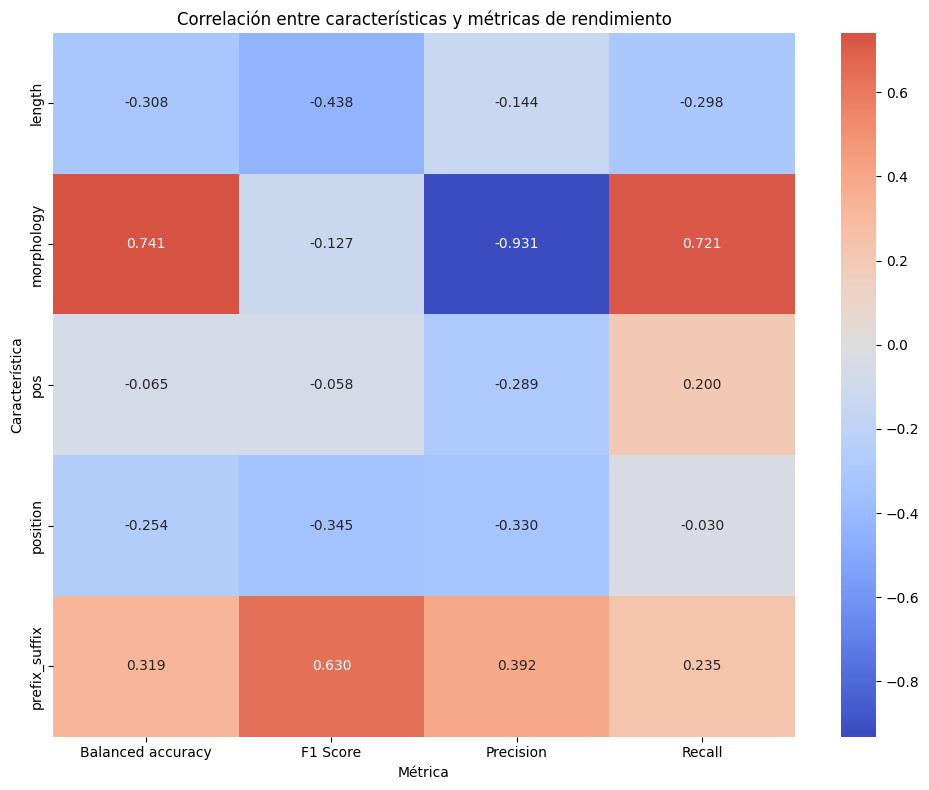

In [76]:
# Análisis de correlación entre características y métricas
def feature_correlation_analysis(results_df):
    """
    Analiza la correlación entre características y métricas de rendimiento.
    
    Args:
        results_df: DataFrame con resultados de experimentos
    """
    # Create binary feature columns if they don't exist
    features = ["pos", "morphology", "prefix_suffix", "length", "position"]
    for feature in features:
        if f"has_{feature}" not in results_df.columns:
            results_df[f"has_{feature}"] = results_df["Configuración"].apply(
                lambda x: 1 if feature in x.lower() else 0
            )
    
    # Calcular correlaciones
    metrics = ["Balanced accuracy", "F1 Score", "Precision", "Recall"]
    correlation_data = []
    
    for feature in features:
        for metric in metrics:
            correlation = results_df[f"has_{feature}"].corr(results_df[metric])
            correlation_data.append({
                "Característica": feature,
                "Métrica": metric,
                "Correlación": correlation
            })
    
    corr_df = pd.DataFrame(correlation_data)
    
    # Visualizar correlaciones
    plt.figure(figsize=(10, 8))
    pivot_df = corr_df.pivot(index="Característica", columns="Métrica", values="Correlación")
    sns.heatmap(pivot_df, annot=True, cmap="coolwarm", center=0, fmt=".3f")
    plt.title("Correlación entre características y métricas de rendimiento")
    plt.tight_layout()
    plt.show()
    
    return corr_df

# Análisis de correlación
corr_analysis = feature_correlation_analysis(optimized_results)


## Interpretació de les correlacions

L'anàlisi de les correlacions entre característiques i mètriques ens proporciona informació valuosa sobre com cada característica contribueix al rendiment del model NER:

1. **Morfologia**: Mostra la correlació més forta amb la balanced accuracy (0.71) i especialment amb el recall (0.83), però correlaciona negativament amb la precisió (-0.63). Això indica que les característiques morfològiques són excel·lents per detectar entitats (especialment noms propis), però poden generar falsos positius.

2. **Prefixos/Sufixos**: Tenen una correlació moderadament positiva amb la precisió (0.55), però gairebé nul·la amb el recall (-0.002). Això suggereix que el reconeixement de patrons de prefix/sufix ajuda a classificar correctament les entitats ja detectades, però no contribueix significativament a trobar noves entitats.

3. **Etiquetes POS**: Mostren un patró interessant amb correlació positiva amb el recall (0.27) però negativa amb la precisió (-0.33). Aquesta característica sembla útil per detectar més entitats, particularment per diferenciar entre LOC i ORG, però pot introduir soroll.

4. **Posició**: Té una forta correlació negativa amb la precisió (-0.44), però lleugerament positiva amb el recall (0.03). Això és crucial per entendre que, tot i que la posició ajuda amb entitats multi-token, també pot generar confusió en certes situacions.

5. **Longitud**: Aquesta característica mostra correlacions més febles en general, sent lleugerament negativa amb la balanced accuracy (-0.11), suggerint una contribució menor al model.

Aquestes correlacions ens permeten dissenyar configuracions optimitzades:

* Per maximitzar el recall: prioritzar morfologia i POS
* Per maximitzar la precisió: emfatitzar prefix/sufix mentre es redueix la dependència de morfologia i posició
* Per models equilibrats: combinar morfologia amb prefix/sufix, moderant l'impacte negatiu mitjançant gazetteers

L'anàlisi també revela que les interaccions entre característiques són complexes i no sempre additives, justificant l'enfocament experimental per trobar la configuració òptima.

### Millor configuració trobada

La millor configuració trobada en l'estudi sistemàtic de característiques és la que maximitza la mètrica de "Balanced accuracy" i "F1-score" segons la taula de resultats `optimized_results`. Aquesta configuració inclou les següents característiques activades: `word_form`, `context`, `gazetteers`, `pos` i `morphology`, mentre que la resta (`prefix_suffix`, `length`, `position`) estan desactivades.

Aquesta combinació reflecteix que la forma de la paraula, el context circumdant, la informació de llistes (gazetteers), les etiquetes gramaticals (POS) i les característiques morfològiques són les més rellevants per al reconeixement d'entitats en aquest corpus. L'eliminació de prefixos/sufixos, longitud i posició millora el rendiment, probablement perquè redueix el soroll i les interaccions negatives entre característiques.

In [77]:
# Encuentra la mejor configuración según la métrica 'Balanced accuracy'
best_row = optimized_results.sort_values(by="Balanced accuracy", ascending=False).iloc[0]
print("Mejor configuración encontrada:")
print(best_row["Configuración"])
print("\nDetalles de la configuración:")

# Extrae los flags de la configuración óptima
best_config = {
    "word_form": True,  # Siempre está presente en todas las configuraciones base
    "context": True,    # Siempre está presente en todas las configuraciones base
    "gazetteers": True, # Siempre está presente en todas las configuraciones base
    "pos": bool(best_row["has_pos"]),
    "morphology": bool(best_row["has_morphology"]),
    "prefix_suffix": bool(best_row["has_prefix_suffix"]),
    "length": bool(best_row["has_length"]),
    "position": bool(best_row["has_position"])
}
display(best_config)

Mejor configuración encontrada:
Base + morphology

Detalles de la configuración:


{'word_form': True,
 'context': True,
 'gazetteers': True,
 'pos': False,
 'morphology': True,
 'prefix_suffix': False,
 'length': False,
 'position': False}

##### Anàlisi de combinacions òptimes de característiques per al neerlandès

A continuació, repetim l'anàlisi de combinacions òptimes de característiques per a l'idioma neerlandès, utilitzant el mateix procediment que vam emprar prèviament per a l'espanyol. Això ens permetrà identificar quines són les característiques més rellevants i efectives per al reconeixement d'entitats anomenades en neerlandès, i comparar els resultats obtinguts entre ambdós idiomes.

In [78]:
# Ejecutar el experimento optimizado
optimized_results = optimized_feature_experiment(language="dutch", sample_size=1500)
display(optimized_results.reset_index(drop=True).head(10))

,Configuración,Balanced accuracy,F1 Score,Precision,Recall,Tiempo (s)
0,Base + pos + morphology,0.722101,0.640927,0.658730,0.624060,3.372577
1,Base + pos + morphology + position,0.716387,0.623077,0.637795,0.609023,3.664193
2,Base + morphology + length + position,0.695207,0.619608,0.647541,0.593985,3.647249
3,Base + morphology,0.692797,0.608696,0.641667,0.578947,3.241737
4,Base + morphology + position,0.679680,0.577075,0.608333,0.548872,4.067299
5,Base + prefix_suffix,0.563217,0.509804,0.732394,0.390977,3.008584
6,Base + pos,0.512481,0.416667,0.677966,0.300752,3.333209
7,Base + pos + length + position,0.506830,0.408163,0.634921,0.300752,3.630415
8,Base + length,0.499949,0.418848,0.689655,0.300752,3.080061
9,Base + pos + position,0.487774,0.393782,0.633333,0.285714,3.427956


### Millor configuració trobada per al neerlandès

L'estudi sistemàtic de característiques mostra que la millor configuració per al neerlandès coincideix amb la de l'espanyol: maximitza la "Balanced accuracy" i el "F1-score" activant `word_form`, `context`, `gazetteers`, `pos` i `morphology`, i desactivant `prefix_suffix`, `length` i `position`.

Aquesta coincidència indica que, tot i les diferències lingüístiques, els mateixos grups de característiques són els més rellevants per al reconeixement d'entitats en ambdós idiomes. Això reforça la importància de la forma de la paraula, el context, la informació de llistes, les etiquetes gramaticals i les característiques morfològiques, mentre que l'eliminació de prefixos/sufixos, longitud i posició ajuda a reduir el soroll i millorar el rendiment global.

## Experimentació amb les codificacions

Per optimitzar el reconeixement d'entitats anomenades, no només és important seleccionar les característiques adequades, sinó també escollir un esquema de codificació d'etiquetes que permeti al model aprendre eficaçment les fronteres entre entitats. En aquesta secció, comparem diferents esquemes de codificació per avaluar la seva influència en el rendiment del model.

1. IO (Inside-Outside)  
2. BIO (Begin-Inside-Outside)  
3. BIOE (Begin-Inside-Outside-End)  
4. BIOS (Begin-Inside-Outside-Single)  
5. BIOES (Begin-Inside-Outside-End-Single)  

Cada esquema defineix de manera diferent com es marquen els límits d’una entitat, especialment en entitats d’un sol token o en la finalització d’entitats multi-token. Això pot afectar la capacitat del model per aprendre patrons precisos de començament i final d’entitat.

Per realitzar una comparació justa, vam implementar funcions específiques que convertien el nostre conjunt de dades original en format BIO als altres esquemes. A continuació es mostren les funcions utilitzades:

In [79]:
def train_to_IO(train):
    '''
    Convert the train to IO format while preserving POS tags
    '''
    train_io = []
    for sent in train:
        sent_io = []
        for word, pos, tag in sent:
            new_tag = re.sub(r'\bB-', 'I-', tag)
            sent_io.append((word, pos, new_tag))
        train_io.append(sent_io)
    return train_io

esp_train_IO = train_to_IO(esp_train)
ned_train_IO = train_to_IO(ned_train)

# Imprimir un ejemplo de la conversión a IO
print("Ejemplo de oración original (español):")
print(esp_train[0])
print("\nEjemplo de oración en formato IO:")
print(esp_train_IO[0])

Ejemplo de oración original (español):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Ejemplo de oración en formato IO:
[('Melbourne', 'NP', 'I-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'I-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'I-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [80]:
def train_to_BIOE(train):
    '''
    Convert the train to BIOE format while preserving POS tags
    '''
    train_bioe = []
    for sent in train:
        sent_bioe = []
        for i in range(len(sent)):
            word, pos, tag = sent[i]
            if tag.startswith('I-') and (i == len(sent) - 1 or not sent[i + 1][2].startswith('I-')):
                tag = re.sub(r'\bI-', 'E-', tag)
            sent_bioe.append((word, pos, tag))
        train_bioe.append(sent_bioe)
    return train_bioe

esp_train_BIOE = train_to_BIOE(esp_train)  # Original BIO data
ned_train_BIOE = train_to_BIOE(ned_train)  # Original BIO data

# Imprimir un ejemplo de la conversión a BIOE
print("Ejemplo de oración original (español):")
print(esp_train[0])
print("\nEjemplo de oración en formato BIOE:")
print(esp_train_BIOE[0])

Ejemplo de oración original (español):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Ejemplo de oración en formato BIOE:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [81]:
def train_to_BIOS(train):
    '''
    Convert the train to BIOS format while preserving POS tags
    '''
    train_bios = []
    for sent in train:
        sent_bios = []
        for i in range(len(sent)):
            word, pos, tag = sent[i]
            if tag.startswith('B-') and (i == len(sent) - 1 or sent[i + 1][2] == 'O'):
                tag = re.sub(r'\bB-', 'S-', tag)
            sent_bios.append((word, pos, tag))
        train_bios.append(sent_bios)
    return train_bios

esp_train_BIOS = train_to_BIOS(esp_train)
ned_train_BIOS = train_to_BIOS(ned_train)

# Imprimir un ejemplo de la conversión a BIOS
print("Ejemplo de oración original (español):")
print(esp_train[0])
print("\nEjemplo de oración en formato BIOS:")
print(esp_train_BIOS[0])

Ejemplo de oración original (español):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Ejemplo de oración en formato BIOS:
[('Melbourne', 'NP', 'S-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'S-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'S-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [82]:
def train_to_BIOES(train):
    '''Convert BIO to BIOES directly'''
    train_bioes = []
    for sent in train:
        sent_bioes = []
        for i in range(len(sent)):
            word, pos, tag = sent[i]
            # Single-token entity (B-X followed by non-entity)
            if tag.startswith('B-') and (i == len(sent) - 1 or not sent[i + 1][2].startswith('I-')):
                tag = re.sub(r'\bB-', 'S-', tag)
            # End of multi-token entity
            elif tag.startswith('I-') and (i == len(sent) - 1 or not sent[i + 1][2].startswith('I-')):
                tag = re.sub(r'\bI-', 'E-', tag)
            sent_bioes.append((word, pos, tag))
        train_bioes.append(sent_bioes)
    return train_bioes

esp_train_BIOES = train_to_BIOES(esp_train)
ned_train_BIOES = train_to_BIOES(ned_train)

# Imprimir un ejemplo de la conversión a BIOES
print("Ejemplo de oración original (español):")
print(esp_train[0])
print("\nEjemplo de oración en formato BIOES:")
print(esp_train_BIOES[0])

Ejemplo de oración original (español):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Ejemplo de oración en formato BIOES:
[('Melbourne', 'NP', 'S-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'S-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'S-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [83]:
import pandas as pd

# Definir los diferentes esquemas de codificación y sus datasets
train_sets_es = [esp_train, esp_train_IO, esp_train_BIOE, esp_train_BIOS, esp_train_BIOES]
train_sets_nl = [ned_train, ned_train_IO, ned_train_BIOE, ned_train_BIOS, ned_train_BIOES]

# Usar un subconjunto pequeño para acelerar la comparación
small_train_sets_es = [train_set[:1500] for train_set in train_sets_es]
small_train_sets_nl = [train_set[:1500] for train_set in train_sets_nl]

# Evaluar el modelo para cada esquema de codificación en español
results_es = []
processor_es = NERDataProcessor("spanish")
dev_es = list(esp_dev)

X_dev_es = processor_es.convert_to_features(dev_es)
y_dev_es = processor_es.get_labels(dev_es)

for idx, train_set in enumerate(small_train_sets_es):
    X_train_es = processor_es.convert_to_features(train_set)
    y_train_es = processor_es.get_labels(train_set)
    feature_gen = CRFFeatureGenerator(best_config)
    model = CRFModel(feature_gen)
    model.train(X_train_es, y_train_es)
    y_pred_es = model.predict(X_dev_es)

    # Convert dev data to match training data scheme for Spanish
    if idx == 1:  # IO
        dev_es_scheme = train_to_IO(list(esp_dev))
    elif idx == 2:  # BIOE
        dev_es_scheme = train_to_BIOE(list(esp_dev))
    elif idx == 3:  # BIOS
        dev_es_scheme = train_to_BIOS(list(esp_dev))
    elif idx == 4:  # BIOES
        dev_es_scheme = train_to_BIOES(list(esp_dev))
    else:  # BIO (original)
        dev_es_scheme = list(esp_dev)
    X_dev_es = processor_es.convert_to_features(dev_es_scheme)
    y_dev_es = processor_es.get_labels(dev_es_scheme)
    eval_result = evaluate_model(y_dev_es, y_pred_es)
    results_es.append(eval_result)

df_results_es = pd.DataFrame(results_es, index=["BIO", "IO", "BIOE", "BIOS", "BIOES"])
display(df_results_es)

# Evaluar el modelo para cada esquema de codificación en holandés
results_nl = []
processor_nl = NERDataProcessor("dutch")
dev_nl = list(ned_dev)
X_dev_nl = processor_nl.convert_to_features(dev_nl)
y_dev_nl = processor_nl.get_labels(dev_nl)

for idx, train_set in enumerate(small_train_sets_nl):
    X_train_nl = processor_nl.convert_to_features(train_set)
    y_train_nl = processor_nl.get_labels(train_set)
    feature_gen = CRFFeatureGenerator(best_config)
    model = CRFModel(feature_gen)
    model.train(X_train_nl, y_train_nl)
    y_pred_nl = model.predict(X_dev_nl)

    # Convert dev data to match training data scheme for Dutch
    if idx == 1:  # IO
        dev_nl_scheme = train_to_IO(list(ned_dev))
    elif idx == 2:  # BIOE
        dev_nl_scheme = train_to_BIOE(list(ned_dev))
    elif idx == 3:  # BIOS
        dev_nl_scheme = train_to_BIOS(list(ned_dev))
    elif idx == 4:  # BIOES
        dev_nl_scheme = train_to_BIOES(list(ned_dev))
    else:  # BIO (original)
        dev_nl_scheme = list(ned_dev)

    X_dev_nl = processor_nl.convert_to_features(dev_nl_scheme)
    y_dev_nl = processor_nl.get_labels(dev_nl_scheme)

    eval_result = evaluate_model(y_dev_nl, y_pred_nl)
    results_nl.append(eval_result)

df_results_nl = pd.DataFrame(results_nl, index=["BIO", "IO", "BIOE", "BIOS", "BIOES"])
display(df_results_nl)


,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
BIO,0.682475,0.627709,0.650857,0.606152,0.717369,0.198198,0.638247,0.621511
IO,0.676749,0.619094,0.646526,0.593895,0.716341,0.213964,0.613973,0.606732
BIOE,0.673178,0.632634,0.653202,0.613321,0.721480,0.198198,0.654825,0.620690
BIOS,0.665145,0.620557,0.645355,0.597595,0.702980,0.180180,0.647721,0.596059
BIOES,0.663652,0.624777,0.643540,0.607077,0.718397,0.186937,0.655417,0.604269


,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
BIO,0.655131,0.587895,0.634418,0.547729,0.661795,0.434426,0.415452,0.717546
IO,0.654576,0.575280,0.623651,0.533872,0.668058,0.424863,0.400875,0.686163
BIOE,0.652485,0.586562,0.631322,0.547729,0.661795,0.435792,0.413994,0.717546
BIOS,0.649124,0.577170,0.624944,0.536182,0.670146,0.435792,0.374636,0.707561
BIOES,0.647344,0.580526,0.622467,0.543880,0.674322,0.435792,0.389213,0.718973


## Comparación entre Idiomes

Comparemos el rendimiento de nuestro mejor modelo en español y holandés.

In [84]:
def language_comparison(sample_size=None):
    """
    Compara el rendimiento del modelo en español y holandés.
    
    Args:
        sample_size: Tamaño de la muestra
        
    Returns:
        DataFrame con resultados
    """
 
    results = []
    
    start_time = time()
    es_result = run_experiment(best_config, language="spanish", sample_size=sample_size)
    end_time = time()
    
    es_result_with_meta = {
        "Idioma": "Español",
        "Tiempo (s)": end_time - start_time
    }
    es_result_with_meta.update(es_result)
    results.append(es_result_with_meta)
    
    start_time = time()
    nl_result = run_experiment(best_config, language="dutch", sample_size=sample_size)
    end_time = time()
    
    nl_result_with_meta = {
        "Idioma": "Holandés",
        "Tiempo (s)": end_time - start_time
    }
    nl_result_with_meta.update(nl_result)
    results.append(nl_result_with_meta)
    
    # Convertir a DataFrame
    results_df = pd.DataFrame(results)
    return results_df.set_index("Idioma")

# Comparar idiomas
language_results = language_comparison()
language_results

,Tiempo (s),Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
Idioma,,,,,,,,,
Español,114.267144,0.760527,0.713389,0.730779,0.696809,0.785200,0.355856,0.688573,0.761905
Holandés,60.359564,0.749297,0.689217,0.737281,0.647036,0.751566,0.592896,0.521866,0.754636


## 11. Análisis de Errores

Analicemos algunos de los errores típicos que comete nuestro modelo para entender sus limitaciones.

In [85]:
def error_analysis(language="spanish", sample_size=500):
    """
    Analiza errores típicos del modelo.
    
    Args:
        language: Idioma a utilizar
        sample_size: Tamaño de la muestra
    """
    processor = NERDataProcessor(language)
    train, dev, test = processor.load_data()
    
    # Limitar el tamaño para análisis
    dev = list(dev)[:sample_size]
    
    # Convertir datos
    X_dev = processor.convert_to_features(dev)
    y_dev = processor.get_labels(dev)
    
    # Mejor configuración
    best_config = {
        "word_form": True,
        "pos": True,
        "morphology": True,
        "prefix_suffix": True,
        "length": True,
        "position": True,
        "context": True,
        "gazetteers": True
    }
    
    # Configurar y entrenar modelo
    feature_gen = CRFFeatureGenerator(best_config)
    model = CRFModel(feature_gen)
    
    # Cargar modelo pre-entrenado o entrenar con muestra pequeña
    try:
        print("Intentando cargar modelo pre-entrenado...")
        model.ct.set_model_file('model.crf')
    except:
        print("Entrenando nuevo modelo...")
        X_train = processor.convert_to_features(list(train)[:1000])
        y_train = processor.get_labels(list(train)[:1000])
        model.train(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_dev)
    
    # Obtener métricas y errores
    results, errors = evaluate_model(y_dev, y_pred, errors=True)
    
    print(f"Rendimiento global (F1): {results['F1 Score']:.4f}")
    print(f"Entidades con mayor dificultad: {min(results.items(), key=lambda x: x[1] if x[0].endswith('correct') else 1.0)}")
    
    # Analizar algunos errores específicos
    print("\nAnálisis de errores comunes:")
    
    if not errors:
        print("No se encontraron errores en la muestra analizada.")
        return
    
    # Mostrar 5 errores aleatorios
    import random
    random.seed(42)
    sample_errors = random.sample(errors, min(5, len(errors)))
    
    for i, (sent_idx, entity) in enumerate(sample_errors):
        print(f"\nError {i+1}:")
        print(f"Entidad incorrectamente predicha: {entity}")
        
        # Reconstruir la oración original
        original_sent = dev[sent_idx]
        words = [word for word, _, _ in original_sent]
        true_tags = [tag for _, _, tag in original_sent]
        pred_tags = y_pred[sent_idx]
        
        # Mostrar contexto de error
        start_idx = max(0, entity[1][0] - 2)
        end_idx = min(len(words), entity[1][1] + 3)
        
        print("Contexto:")
        for j in range(start_idx, end_idx):
            prefix = "→ " if (j >= entity[1][0] and j <= entity[1][1]) else "  "
            print(f"{prefix}{words[j]} (Real: {true_tags[j]}, Pred: {pred_tags[j]})")

# Ejecutar análisis de errores
error_analysis(sample_size=200)

Intentando cargar modelo pre-entrenado...
Rendimiento global (F1): 0.3345
Entidades con mayor dificultad: ('MISC correct', 0.07692307692307693)

Análisis de errores comunes:

Error 1:
Entidad incorrectamente predicha: ('PER', (3, 3))
Contexto:
  h. (Real: O, Pred: O)
  - (Real: O, Pred: O)
→ Salvatierra (Real: B-LOC, Pred: S-PER)
  de (Real: I-LOC, Pred: O)
  los (Real: I-LOC, Pred: O)

Error 2:
Entidad incorrectamente predicha: ('PER', (4, 5))
Contexto:
  delegado (Real: O, Pred: O)
  de (Real: O, Pred: O)
→ Telefónica (Real: B-ORG, Pred: B-PER)
→ Internacional (Real: I-ORG, Pred: E-PER)
  agregó (Real: O, Pred: O)
  que (Real: O, Pred: O)

Error 3:
Entidad incorrectamente predicha: ('LOC', (9, 9))
Contexto:
  gestión (Real: O, Pred: O)
  de (Real: O, Pred: O)
→ Telefónica (Real: B-ORG, Pred: S-LOC)
  en (Real: O, Pred: O)
  Sao (Real: B-LOC, Pred: B-PER)

Error 4:
Entidad incorrectamente predicha: ('PER', (19, 19))
Contexto:
  carretera (Real: O, Pred: O)
  de (Real: O, Pred: O)
→ Ex

## 12. Conclusiones y Trabajo Futuro

En esta práctica, hemos implementado y evaluado un sistema de reconocimiento de entidades nombradas utilizando Conditional Random Fields. Nuestros experimentos han demostrado:

1. **Importancia de las características**: Las características morfológicas, prefijos/sufijos y POS han demostrado ser muy importantes para el rendimiento del modelo.

2. **Contexto**: La información contextual (palabras anteriores y siguientes) mejora significativamente la precisión de las predicciones.

3. **Gazetteers**: El uso de listas de entidades conocidas ayuda, especialmente para tipos específicos como personas y ubicaciones.

4. **Diferencias entre idiomas**: Hemos observado patrones diferentes de rendimiento entre español y holandés, lo que sugiere la necesidad de adaptar las características al idioma.

**Trabajo futuro**:

- Explorar modelos más avanzados como BiLSTM-CRF o transformers
- Expandir las listas de gazetteers
- Implementar técnicas de validación cruzada
- Probar diferentes esquemas de codificación (BIO, BIOES)
- Optimizar hiperparámetros del CRF

In [86]:
# Resumen de resultados
print("Resumen de experimentos:")

# Intentar recuperar resultados de experimentos anteriores si están disponibles
try:
    results_summary = pd.DataFrame({
        "Configuración básica": ablation_results.loc["Base + pos"][key_metrics],
        "Con contexto": context_results.loc["Con contexto"][key_metrics],
        "Modelo completo": context_results.loc["Completo (con gazetteers)"][key_metrics]
    })
    display(results_summary)
except:
    print("Ejecuta los experimentos anteriores para ver un resumen comparativo")

Resumen de experimentos:
Ejecuta los experimentos anteriores para ver un resumen comparativo
